In [1]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cb_tools
from pygam import LinearGAM
from scipy import stats

In [2]:
# set results path
results_dir = '/nfs/s2/userhome/liuxingyu/workingdir/cerebellum_grad_dev'

In [3]:
# prepare roi data
data_t1wT2wRatio = pd.read_csv(os.path.join(results_dir, 't1wT2wRatio', 't1wT2wRatio_cb_anat_fsl.csv'))
data_falff = pd.read_csv(os.path.join(results_dir, 'fALFF', 'fALFF_cb_anat_cifti.csv'))

atlas_dir = os.path.join(os.getcwd(), 'atlas')
atlas = cb_tools.atlas_load('cb_anat_fsl', atlas_dir)

num_str_col = 6
palette_cb = sns.diverging_palette(230,230, l=80, center='dark', n=9)

In [4]:
def hemi_merging(x, num_str_col):
    x_l = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='l']]
    x_l.rename(columns=lambda x: x.split('_')[0], inplace=True)
    
    x_r = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='r']]   
    x_r.rename(columns=lambda x: x.split('_')[0], inplace=True)

    x_merged = pd.concat([pd.concat([x_l,x_r]).mean(level=0),x.iloc[:,-num_str_col:]], axis=1)
    
    return x_merged

data_t1wT2wRatio = hemi_merging(data_t1wT2wRatio, num_str_col)
data_falff = hemi_merging(data_falff, num_str_col)
lobues_name = atlas.label_info['lobule'][:18:2]

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
def inner_sub(dataframe_list):
    sub = set(dataframe_list[0]['Sub'].tolist())
    for dataframe in dataframe_list[1:]:
        sub = sub & set(dataframe['Sub'].tolist())
    return list(sub)       
    
#sub = inner_sub([data_ml, data_alff, sub_adult])
sub = inner_sub([data_t1wT2wRatio.query('`Age_in_years` < 22'), data_falff.query('`Age_in_years` < 22')])
sub_df = pd.DataFrame(sub, columns=['Sub'])
data_t1wT2wRatio_coup = data_t1wT2wRatio.merge(sub_df, on='Sub', how='inner')
data_falff_coup = data_falff.merge(sub_df, on='Sub', how='inner')


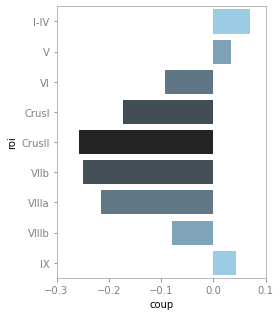

In [6]:
# plot Fig 2h
dev_coup = np.asarray([stats.pearsonr(data_t1wT2wRatio_coup[col], data_falff_coup[col])
                       for col in data_t1wT2wRatio_coup.columns[:-num_str_col]])
# isc
isc_df = pd.DataFrame(np.c_[dev_coup[:,0], data_falff_coup.columns[:-num_str_col]], columns=['coup', 'roi']) 
fig, ax = plt.subplots(figsize=(4, 4.5))
sns.barplot(x='coup', y='roi', palette=palette_cb, linewidth=1, data=isc_df, ax=ax)

ax.tick_params(colors='gray', which='both')
[ax.spines[k].set_color('darkgray') for k in ['top','bottom','left','right']]
ax.set_xlim(-0.3, 0.1)
plt.tight_layout()

In [7]:
def isc(data1, data2=None):

    """calculate inter-subject correlation along the determined axis.

    Parameters
    ----------

        data1: used to calculate functional connectivity,
            shape = [n_samples, n_features].
        data2: used to calculate functional connectivity,
            shape = [n_samples, n_features].

    Returns
    -------
        isc: point-to-point functional connectivity list of
            data1 and data2, shape = [n_samples, ].

    Notes
    -----
        1. data1 and data2 should both be 2-dimensional.
        2. [n_samples, n_features] should be the same in data1 and data2.

    """

    if data2 is None:
        data2 = data1
    data1 = np.nan_to_num(data1)
    data2 = np.nan_to_num(data2)

    z_data1 = np.nan_to_num(stats.zscore(data1, axis=-1))
    z_data2 = np.nan_to_num(stats.zscore(data2, axis=-1))
    corr = np.sum(z_data1*z_data2, axis=-1)/(np.size(data1, -1))

    return corr

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


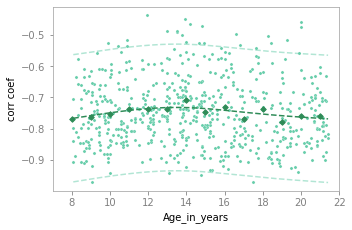

In [10]:
# %% plot fig 2i
coup = isc(data_t1wT2wRatio_coup.iloc[:,:-num_str_col], data_falff_coup.iloc[:,:-num_str_col])
coup = pd.DataFrame(coup, columns=['coup'])
coup = pd.concat((coup, data_t1wT2wRatio_coup.iloc[:,-num_str_col:]), axis=1)

# threshold by 3 IQR
data = copy.deepcopy(coup)
data[data.columns[:-num_str_col]] = cb_tools.thr_IQR(data[data.columns[:-num_str_col]].values, times=3, series=True) # remove outliers
data.dropna(inplace=True)
data_g = data.groupby(['Age_in_years']).mean().loc[:, data.columns[:-num_str_col]]

# plot dev trajactory
x = 'Age_in_months'
y = 'coup'
_, ax = plt.subplots(nrows=1, ncols=1, figsize=[5,3.3])  

sns.scatterplot(data[x]/12, data[y], s=10, color='mediumaquamarine', ax=ax)
gam = LinearGAM(n_splines=20).gridsearch(data[x].values[...,None]/12, data[y].values)
xx = gam.generate_X_grid(term=0, n=500)
        
ax.plot(xx, gam.predict(xx), '--', color='seagreen')
ax.plot(xx, gam.prediction_intervals(xx, width=.95), color='mediumaquamarine', ls='--', alpha=0.5)
ax.scatter(data_g.index, data_g[y], c='seagreen', s=15, marker='D')
    
ax.set_xticks(np.arange(8, 23, 2))
ax.set_xlim([7,22])
ax.set_xlabel('Age_in_years')
ax.set_ylabel('corr coef')
ax.tick_params(colors='gray', which='both')
[ax.spines[k].set_color('darkgray') for k in ['top','bottom','left','right']]
    
plt.tight_layout()